Processing Ring dataset...
Dataset: Ring, Model: SVM, Best Params: {'C': 10, 'kernel': 'rbf'}, Accuracy: 0.98
ROC AUC: 1.00


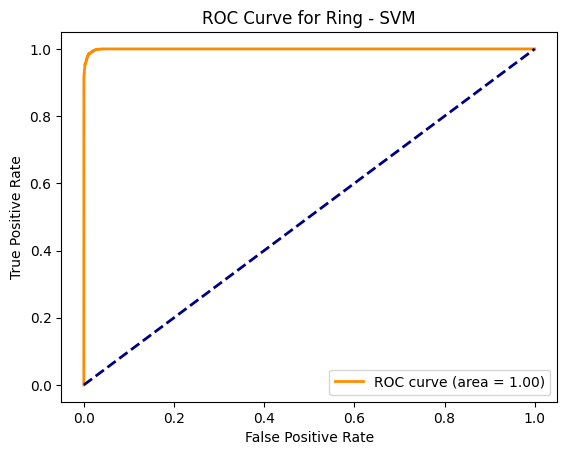

Dataset: Ring, Model: MLR, Best Params: {'C': 0.1}, Accuracy: 0.53
ROC AUC: 0.50


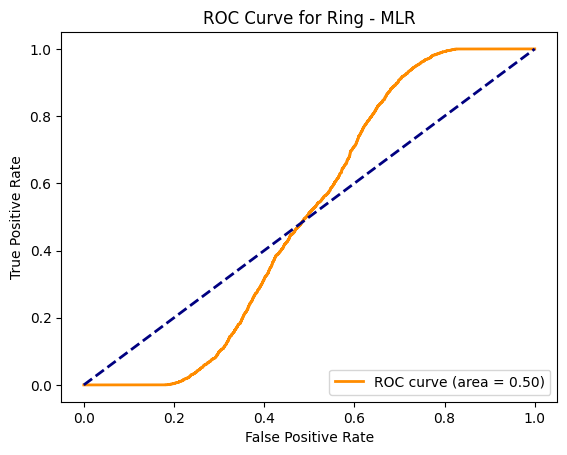

/Users/mwr/.conda/envs/A2_RACCA/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Dataset: Ring, Model: BP, Best Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}, Accuracy: 0.94
ROC AUC: 0.98


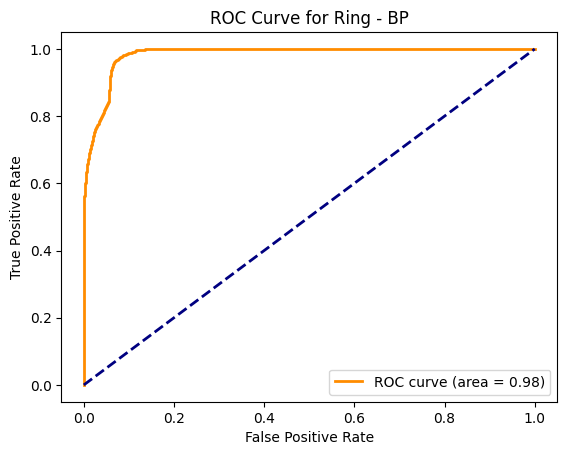

Processing Diabetes dataset...


/Users/mwr/.conda/envs/A2_RACCA/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains NaN.

In [17]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Function to split features and targets
def split_features_target(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    # Handle NaN values in target
    y = y.replace(np.nan, 0) # Replace NaN with 0 or other appropriate value
    # Convert target to numeric if it's not
    if y.dtype == 'object':
        y = y.map({'yes': 1, 'no': 0})
    return X, y

# Load the datasets
ring_train = pd.read_csv('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/ring_merged_scaled.csv', header=None)
ring_test = pd.read_csv('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/ring_test_scaled.csv', header=None)
bank_train = process_bank_dataset('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/bank_train.csv')
bank_test = process_bank_dataset('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/bank_test.csv')
diabetes_train = pd.read_csv('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/diabetes_train_val.csv', header=None)
diabetes_test = pd.read_csv('https://raw.githubusercontent.com/raccamateo/NEC_A2/main/diabetes_test.csv', header=None)

# Split features and target for each dataset
ring_train_features, ring_train_target = split_features_target(ring_train)
ring_test_features, ring_test_target = split_features_target(ring_test)
bank_train_features, bank_train_target = split_features_target(bank_train)
bank_test_features, bank_test_target = split_features_target(bank_test)
diabetes_train_features, diabetes_train_target = split_features_target(diabetes_train)
diabetes_test_features, diabetes_test_target = split_features_target(diabetes_test)

# Compile datasets into a dictionary
datasets = {
    'Ring': (ring_train_features, ring_train_target, ring_test_features, ring_test_target),
    'Bank': (bank_train_features, bank_train_target, bank_test_features, bank_test_target), # Commented out
    'Diabetes': (diabetes_train_features, diabetes_train_target, diabetes_test_features, diabetes_test_target)
}

# Define model configurations
model_params = {
    'SVM': {
        'model': SVC(probability=True),  # Enable probability for ROC AUC
        'params': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly']}
    },
    'MLR': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10]}
    },
    'BP': {
        'model': MLPClassifier(max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    }
}

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

# Dictionary to store results
results = {}

# Training, tuning, and evaluation process
for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
    if dataset_name != 'Bank':  # Skip the Bank dataset
        print(f"Processing {dataset_name} dataset...")
        for model_name, mp in model_params.items():
            clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy')
            clf.fit(X_train, y_train)

            # Evaluate on test set
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf.best_estimator_, "predict_proba") else None
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            conf_mat = confusion_matrix(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

            # Store results
            results[(dataset_name, model_name)] = {
                'best_params': clf.best_params_,
                'accuracy': accuracy,
                'confusion_matrix': conf_mat,
                'roc_auc': roc_auc
            }

            # Output results
            print(f"Dataset: {dataset_name}, Model: {model_name}, Best Params: {clf.best_params_}, Accuracy: {accuracy:.2f}")
            if roc_auc:
                print(f"ROC AUC: {roc_auc:.2f}")
                plot_roc_curve(y_test, y_pred_proba, f"{dataset_name} - {model_name}")

